<a href="https://colab.research.google.com/github/AdrianduPlessis/UBI_Effects/blob/master/ML_Project_Proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hidden Effects of a UBI

Universal Basic Income (UBI) is not a new idea, I myself was introduced to the idea when Elon Musk first mentioned it in an interview back in 2017. Recently one of the democratic candidates, Andrew Yang, has been moving the idea closer to reality than it has ever been (on a massive scale, at least). With more attention than ever on UBI, some interesting opinions are being aired as to the possible social implications this massive economic disruption might have.  

Thinking through these issues myself, a lucky synapse fired reminding me of the Gini Index. The Gini Index is essentially a metric representing the inequality of income distribution within a certain geography. A UBI would obviously have the effect of lowering the Gini Index, most drastically on the bottom end. 
 
'Alright, so what?' I can hear you thinking. So this: The only reason I remember anything at all from the obscure YouTube video that introduced me to the Gini Index is because of the powerful correlation that exists between the Gini Index and adult_arrests rates. Anywhere on the spectrum... if you take two of the weathiest neighborhoods California, for example, and calculate the Gini Index for just those two neighborhoods, the neighborhood with the higher Gini Coefficient will (with some confidence) have the higher adult_arrests rate.  

'Neato, but so what?' Well, let me put it to you that using per county Gini Index, Income, and adult_arrests Rate data-- a decent ML model should be able to predict the reduction in adult_arrests rates of a given UBI ammount.  

**What's more:** that predicted reduction in adult_arrests-rate could be translated into reduced cost of incarseration (including burden of legal fees) to the government, information that would be very useful to a hopeful candidate trying to explain the value of the idea that their political campaign is based on.

#Hyp: income inequality -> adult_arrests


Hypothesis A: There exists a (statistically significant) correlation between Gini Coefficient (Income Inequality) and adult_arrestsrates within a specific county/state.

Determine p-values for individual counties' gini-to-adult_arrests over time.  
Determine p-values for counties' gini-to-adult_arrests for a given year.

##Tools of the trade

In [0]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
#Imports for baseline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

##Import Datasets

In [0]:
gini_5yr_est_2017 = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/gini_est_5yr_17.csv', skiprows=1)

In [0]:
adult_arrests = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/ICPSR_36399/DS0004/36399-0004-Data.tsv', sep='\t')

In [0]:
FIPS = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/all-geocodes-v2016.xlsx%20-%20Sheet1.csv', skiprows=4)


###Data Wrangling

In [0]:
def change_id_to_fips(id):
  fips = int(id[-5:])
  return fips

In [0]:
gini_5yr_est_2017['Id'].apply(change_id_to_fips);

In [0]:
#Create dictionary to lookup State based on state FIPS
State_FIPS = FIPS[FIPS['County Code (FIPS)']==0]
State_FIPS = State_FIPS[State_FIPS['Summary Level']==40]

lookup_state_FIPS = dict(zip(State_FIPS['State Code (FIPS)'], State_FIPS['Area Name (including legal/statistical area description)']))

In [0]:
adult_arrests['state'] = adult_arrests['FIPS_ST'].map(lookup_state_FIPS)

In [0]:
def combine_cty_st_fips(cty, st):
  full_fips = st*1000 + cty
  return full_fips

In [0]:
FIPS['FIPS'] = combine_cty_st_fips(FIPS['County Code (FIPS)'], FIPS['State Code (FIPS)'])
adult_arrests['FIPS'] = combine_cty_st_fips(adult_arrests['FIPS_CTY'], adult_arrests['FIPS_ST'])

##Merge Datasets

In [0]:
#Note: missing gini data for 35 counties (based on shapes of dfs being merged)
arrest_by_ineq = adult_arrests.merge(gini_5yr_est_2017, left_on='FIPS', right_on='Id2')

In [12]:
arrest_by_ineq.head()

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,CPOPARST,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,VIOL,PROPERTY,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,state,FIPS,Id,Id2,Geography,Estimate; Gini Index,Margin of Error; Gini Index
0,9999,1,4,1,1,1,57217,54579,3,3,100.0000,144,1625,2,18,37,87,386,1110,129,14,Alabama,1001,0500000US01001,1001,"Autauga County, Alabama",0.4501,0.0391
1,9999,1,4,2,1,3,198843,193083,14,13,96.0428,373,4060,4,33,62,274,770,3167,123,18,Alabama,1003,0500000US01003,1003,"Baldwin County, Alabama",0.4618,0.0100
2,9999,1,4,3,1,5,27026,25154,5,4,96.0536,97,660,3,10,14,70,171,454,36,1,Alabama,1005,0500000US01005,1005,"Barbour County, Alabama",0.4622,0.0148
3,9999,1,4,4,1,7,22491,21175,4,5,98.9359,23,227,2,3,2,16,65,143,19,1,Alabama,1007,0500000US01007,1007,"Bibb County, Alabama",0.4518,0.0565
4,9999,1,4,5,1,9,58037,58037,6,6,98.4949,125,1270,0,15,4,106,374,772,124,7,Alabama,1009,0500000US01009,1009,"Blount County, Alabama",0.4302,0.0175


###Further Wrangling

In [0]:
#Engineer feature that controls for variation in population size
def control_for_population(df, feature, population):
  df[feature] = df[feature]/df[population]
  return df

In [0]:
crime_types = ['VIOL', 'PROPERTY', 'MURDER', 'RAPE', 
               'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 
               'MVTHEFT','ARSON']

population = arrest_by_ineq['CPOPARST']

for crime in crime_types:
  arrest_by_ineq[crime] = arrest_by_ineq[crime]/population

In [16]:
arrest_by_ineq.head()

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,CPOPARST,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,VIOL,PROPERTY,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,state,FIPS,Id,Id2,Geography,Estimate; Gini Index,Margin of Error; Gini Index,arrests_per_person
0,9999,1,4,1,1,1,57217,54579,3,3,100.0000,0.002517,0.028401,0.000035,0.000315,0.000647,0.001521,0.006746,0.019400,0.002255,0.000245,Alabama,1001,0500000US01001,1001,"Autauga County, Alabama",0.4501,0.0391,0.028401
1,9999,1,4,2,1,3,198843,193083,14,13,96.0428,0.001876,0.020418,0.000020,0.000166,0.000312,0.001378,0.003872,0.015927,0.000619,0.000091,Alabama,1003,0500000US01003,1003,"Baldwin County, Alabama",0.4618,0.0100,0.020418
2,9999,1,4,3,1,5,27026,25154,5,4,96.0536,0.003589,0.024421,0.000111,0.000370,0.000518,0.002590,0.006327,0.016799,0.001332,0.000037,Alabama,1005,0500000US01005,1005,"Barbour County, Alabama",0.4622,0.0148,0.024421
3,9999,1,4,4,1,7,22491,21175,4,5,98.9359,0.001023,0.010093,0.000089,0.000133,0.000089,0.000711,0.002890,0.006358,0.000845,0.000044,Alabama,1007,0500000US01007,1007,"Bibb County, Alabama",0.4518,0.0565,0.010093
4,9999,1,4,5,1,9,58037,58037,6,6,98.4949,0.002154,0.021883,0.000000,0.000258,0.000069,0.001826,0.006444,0.013302,0.002137,0.000121,Alabama,1009,0500000US01009,1009,"Blount County, Alabama",0.4302,0.0175,0.021883


In [17]:
arrest_by_ineq.shape

(3134, 29)

In [0]:
#Drop NaNs
#Stretch: Impute
arrest_by_ineq = arrest_by_ineq.dropna()

In [19]:
arrest_by_ineq.shape

(3129, 29)

In [20]:
arrest_by_ineq.head()

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,CPOPARST,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,VIOL,PROPERTY,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,state,FIPS,Id,Id2,Geography,Estimate; Gini Index,Margin of Error; Gini Index,arrests_per_person
0,9999,1,4,1,1,1,57217,54579,3,3,100.0000,0.002517,0.028401,0.000035,0.000315,0.000647,0.001521,0.006746,0.019400,0.002255,0.000245,Alabama,1001,0500000US01001,1001,"Autauga County, Alabama",0.4501,0.0391,0.028401
1,9999,1,4,2,1,3,198843,193083,14,13,96.0428,0.001876,0.020418,0.000020,0.000166,0.000312,0.001378,0.003872,0.015927,0.000619,0.000091,Alabama,1003,0500000US01003,1003,"Baldwin County, Alabama",0.4618,0.0100,0.020418
2,9999,1,4,3,1,5,27026,25154,5,4,96.0536,0.003589,0.024421,0.000111,0.000370,0.000518,0.002590,0.006327,0.016799,0.001332,0.000037,Alabama,1005,0500000US01005,1005,"Barbour County, Alabama",0.4622,0.0148,0.024421
3,9999,1,4,4,1,7,22491,21175,4,5,98.9359,0.001023,0.010093,0.000089,0.000133,0.000089,0.000711,0.002890,0.006358,0.000845,0.000044,Alabama,1007,0500000US01007,1007,"Bibb County, Alabama",0.4518,0.0565,0.010093
4,9999,1,4,5,1,9,58037,58037,6,6,98.4949,0.002154,0.021883,0.000000,0.000258,0.000069,0.001826,0.006444,0.013302,0.002137,0.000121,Alabama,1009,0500000US01009,1009,"Blount County, Alabama",0.4302,0.0175,0.021883


In [0]:
#Had to drop 5 counties/observations

In [43]:
corr = arrest_by_ineq.corr()
corr.sort_values('Estimate; Gini Index')['Estimate; Gini Index']

FIPS_ST                       -0.055760
Id2                           -0.055288
FIPS                          -0.055288
IDNO                          -0.053920
RAPE                           0.004323
COVIND                         0.004652
FIPS_CTY                       0.056378
AG_OFF                         0.103482
ARSON                          0.105689
AG_ARRST                       0.131614
CPOPCRIM                       0.145555
CPOPARST                       0.147333
MURDER                         0.178801
MVTHEFT                        0.179110
LARCENY                        0.211482
AGASSLT                        0.224959
Margin of Error; Gini Index    0.232536
PROPERTY                       0.242230
arrests_per_person             0.242230
VIOL                           0.258775
BURGLRY                        0.265313
ROBBERY                        0.317500
Estimate; Gini Index           1.000000
STUDYNO                             NaN
EDITION                             NaN


In [22]:
arrest_by_ineq['Estimate; Gini Index'].corr(arrest_by_ineq['arrests_per_person'])

0.2422302027349367

##Predict adult_arrests on gini coefficient (Baseline)

In [0]:
X = arrest_by_ineq['Estimate; Gini Index'].values.reshape(-1, 1)
y = arrest_by_ineq['arrests_per_person'].values.reshape(-1, 1)

In [93]:
#mean baseline
y_baseline = [y.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_baseline, y_train)
baseline_r2e = mean_squared_error(y_baseline, y_train)
print("Baseline: \n",
      "MAE: ", baseline_mae, '\n',
      "r^2 error: ", baseline_r2e, '\n')

Baseline: 
 MAE:  0.027716429775367007 
 r^2 error:  0.0012354685069545168 



In [0]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, y)  # perform linear regression
y_pred = linear_regressor.predict(X)  # make predictions

In [27]:
mean_squared_error(y, y_pred)

0.0001351165884940218

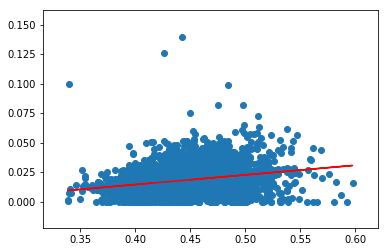

In [34]:
%matplotlib inline
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

#Predict Gini on Reported crime types  

In [0]:
reported_crimes = ['VIOL', 'PROPERTY', 'MURDER', 'RAPE', 
               'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 
               'MVTHEFT','ARSON']

y = arrest_by_ineq['Estimate; Gini Index']
X = arrest_by_ineq[reported_crimes]

In [0]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=42)

In [75]:
model = RandomForestRegressor(criterion='mae')
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [94]:
mean_absolute_error(y_train, y_pred)

0.011114376712328766

In [95]:
mean_squared_error(y_train, y_pred)

0.0002717599153995434

##CV Scores

In [64]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([ 0.01204881, -0.01021742, -0.02627176,  0.07401308,  0.02687276])

##Train, optomize, validate model

##Interpret shaply feature importances

In [48]:
sns.scatterplot(x=X, y=y,alpha=0.1)

ValueError: ignored

#Predict future gini values (optional)

#Apply UBI transform to Gini values

#Predict adult_arrests rate without UBI

#Predict adult_arrests rate with UBI

#Additional Questions:  


##Correlation between income metric and trend in adult_arrests rate?  
positive feedback loop?

##Mean/Median income predictive of type of crime?

#TODO 
11/16/19:  
Merge relevant adult_arrests data.  
Collapse by county.  
